# Classification of hadronic jets
---

### Background

In partcle physics experiments like the [ATLAS](https://atlas.cern/) experiment at [CERN](https://home.cern/), proton-proton ($pp$) collisions often lead to the emission of high-energy colour-charged particles (quarks and gluons; collectively referred to as "partons"). Because colour-charged particles cannot exist in isolation but must be confined in colour-neutral bound states, such high-energy parton emissions will radiate off more particles and eventually hadronise, resulting in a collimated sprays of stable, hadronic particles. Such a spray is called a _jet_, and it manifests as a shower of high-energy particles in experiments like ATLAS.

To reconstruct these jets, robust jet _clustering algorithms_ are typically used. These algorithms cluster particles in the [_pseudorapidity_](https://en.wikipedia.org/wiki/Pseudorapidity) ($\eta$; "eta") vs. _azimuth_ ($\phi$; "phi") plane, that is typically used in particle collider experiments (see note below). You can think of this as a regular, Cartesian $x$- and $y$-axis coordinte system. This clustering proceeds sequentially until a small number of jets are retained. The jet clustering algorithms are characerised by a radius parameter $R$, meaning that you can roughly think of jets as cones of particles in the $\eta-\phi$ coordinate system with a radius of $R$. In this project, a radius parameter of $R = 1$ was used to reconstruct the jets. The particles that are assigned to each jet are called the _constituents_ of the jet.

Now, apart from the more common Standard Model processes resulting in jets, there are also a number of rare processes that give rise to jets. For instance, many models of physics beyond the Standard Model predict the existence of new, high-mass particles that can decay to quarks, which in turn produce jets which are measured in the detector. The challenge is then to classify which jets originated from the rare decay of a massive particle (_e.g._ the $W$ and $Z$ bosons, or hypothesised heavier versions of these, called $W'$ and $Z'$), and which jets originated from the emission of a single, high-energy parton which are copiously produced in known Standard Model interactions.

One way to distinguish between so-called resonant jets, originating from the decay of massive particles, and so-called continuum background jets, originating from the non-resonant emission of single partons, is by their invariant mass: Since all fundamental interactions convser energy and momentum, a particle $Z'$ with mass $m_{Z'}$ decaying to quarks may be reconstructed as a jet with mass $m_{J} \approx m_{Z'}$. This equality is inexact due to the resolution of the experiment; leakage of energy into, or out of, the jet cone; contamination of particles from other $pp$ interactions; _etc._ However, the jet mass is still a very useful discriminator for identifying resonant decays.

The problem is that continuum jets are orders of magnitude more likely to be produced than jets from resonant decays, which means that — purely by chance — there will be a lot of jets with $m_{J} \approx m_{Z'}$ that did _not_ originate from the decay of some massive particle $Z'$. Another way to distinguish jets which happen to have similar masses is through their _substructure:_ "Interesting" jets will typically result from a resonant decay to two or three quarks, each of which produce a collimated spray of particles; this will result in a jet with an internal structure characterised by two or three energic "lobes," also called _subjets_. By contrast, continuum jets will be dominated by a single high-energy emission, and will therefore (to first order of approximation) be comprised of a single, high-energy subjet. We can therefore define a number of high-level variables that attempt to quantify different aspects of this substructure, and thereby hope to better distinguish between these classes of jets. 


## Loading in data
---

In [4]:
# Minimal import(s)
import h5py
import pandas as pd

In [5]:
# Define paths for directories containing the training and testing data, which 
# can be downloaded from the CERNBox mentioned above.
dir_train = 'data/train/'
dir_test  = 'data/test/'

In [6]:
# Load the image dataset
with h5py.File(dir_train + 'images.h5', 'r') as hf: 
    print(list(hf.keys()))
    index  = hf['index'][:]
    signal = hf['signal'][:]
    weight = hf['weight'][:]
    imgsA  = hf['TypeA'][:]
    imgsB  = hf['TypeB'][:]
    imgsC  = hf['TypeC'][:]
    pass

['TypeA', 'TypeB', 'TypeC', 'index', 'signal', 'weight']


In [7]:
# Print the number of training examples of each type
(signal == 0).sum(), (signal == 1).sum(), (signal == 2).sum()

(50000, 50000, 50000)

In [8]:
# Load the high-level variable dataset
df_variables = pd.read_hdf(dir_train + 'variables.h5')
df_variables.head()

,signal,weight,pt,eta,phi,mass,trimmed_mass,tau1,tau2,tau3,...,e2_2,e3_1,e3_2,C2_1,C2_2,D2_1,D2_2,KtDR,split12,zcut12
0,0.0,0.754563,1429.054644,-0.028279,-1.439182,580.472667,577.555367,0.367105,0.123122,0.073896,...,0.172761,0.013206,2.353134e-03,0.216721,0.078841,0.877957,0.456359,0.827116,4.260592,0.030324
1,1.0,1.310081,1408.621118,0.130361,1.020697,141.026068,122.603590,0.086625,0.022405,0.007289,...,0.010039,0.000190,1.966541e-05,0.078947,0.195127,1.607889,19.436861,0.164426,3.186888,0.067179
2,1.0,1.192072,1435.895464,0.920718,1.786299,103.053433,102.466559,0.059406,0.007547,0.006387,...,0.005145,0.000027,5.416519e-08,0.024938,0.002046,0.762363,0.397717,0.165370,2.727562,0.067331
3,0.0,1.041173,1498.936431,-1.539387,1.602722,106.238439,19.442190,0.013582,0.015790,0.010710,...,0.005015,0.000035,5.159801e-06,0.272764,0.205177,24.135950,40.914481,0.012364,1.701913,0.026541
4,2.0,0.635794,1647.535791,-0.091315,2.582996,436.770586,383.033950,0.222138,0.047988,0.029031,...,0.070069,0.002468,4.849675e-04,0.152270,0.098777,1.196044,1.409698,0.552331,3.821762,0.032358


In [9]:
# Load the jet constituents dataset
df_constituents = pd.read_hdf(dir_train + 'constituents.h5')
df_constituents.head()

,signal,weight,pt_0,dEta_0,dPhi_0,pt_1,dEta_1,dPhi_1,pt_2,dEta_2,...,dPhi_96,pt_97,dEta_97,dPhi_97,pt_98,dEta_98,dPhi_98,pt_99,dEta_99,dPhi_99
0,0.0,0.754563,135.673279,0.175755,0.594801,107.982437,0.176698,0.595199,65.615959,-0.135211,...,-0.145322,1.486121,0.120671,0.642919,1.442553,-0.123897,-0.396118,1.307768,0.076032,-0.3082
1,1.0,1.310081,699.050415,-0.072847,0.006429,412.251099,0.113484,0.010931,122.369484,0.052291,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
2,1.0,1.192072,367.651184,0.029980,-0.021788,351.371521,0.034151,-0.017202,214.163300,-0.112072,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
3,0.0,1.041173,727.385193,-0.002188,-0.000067,343.022278,-0.002878,-0.003900,116.583786,-0.004763,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
4,2.0,0.635794,508.912323,-0.098878,-0.077290,320.434662,-0.126295,-0.098470,235.722244,0.354417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000


## Preamble

In [10]:
# Import(s)
import numpy as np 
import matplotlib.pyplot as plt
from daml import plot, project, utilities

### Explore $\boldsymbol{p}_{\mathbf{T}}$-reweighting

In [11]:
var  = 'pt'
bins = np.linspace(1200, 1800., 60+1)

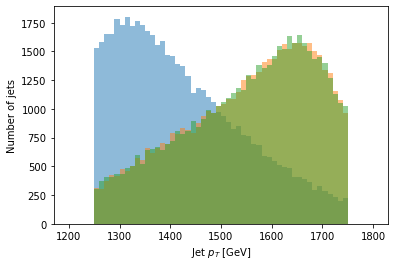

In [12]:
# Jet pT distribution *without* weights
plt.hist(df_variables.query('signal == 0')[var], bins=bins, alpha=0.5);
plt.hist(df_variables.query('signal == 1')[var], bins=bins, alpha=0.5);
plt.hist(df_variables.query('signal == 2')[var], bins=bins, alpha=0.5);
plt.xlabel('Jet $p_{T}$ [GeV]');
plt.ylabel('Number of jets');

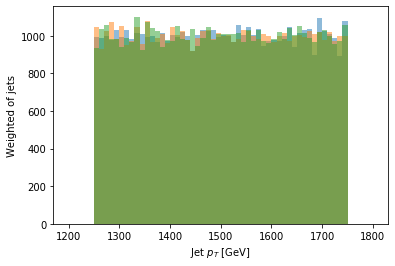

In [13]:
# Jet pT distribution *with* weights
plt.hist(df_variables.query('signal == 0')[var], bins=bins, alpha=0.5, weights=df_variables.query('signal == 0')['weight']);
plt.hist(df_variables.query('signal == 1')[var], bins=bins, alpha=0.5, weights=df_variables.query('signal == 1')['weight']);
plt.hist(df_variables.query('signal == 2')[var], bins=bins, alpha=0.5, weights=df_variables.query('signal == 2')['weight']);
plt.xlabel('Jet $p_{T}$ [GeV]');
plt.ylabel('Weighted of jets');

### Explore images

      Background       |       Signal 1        |       Signal 2


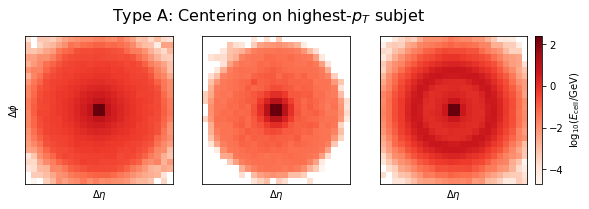

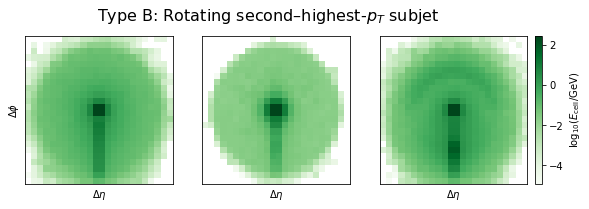

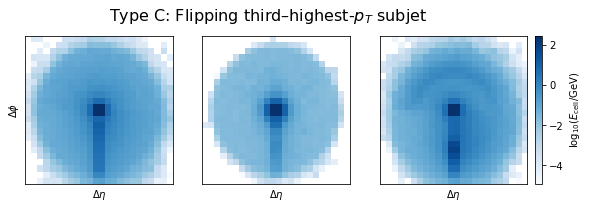

In [14]:
kwargs = dict(layout=(1,3), colorbar='$\\log_{10} (E_{\\mathrm{cell}} / \\mathrm{GeV})$', 
              xlabel='$\\Delta \\eta$', ylabel='$\\Delta \\phi$', size=6)

def GetAverageImage (array):
    averageImage = array.mean(axis=0)
    maskZero     = (averageImage == 0)
    averageImage[maskZero] = 1.0E-09
    averageImage = np.log10(averageImage)
    averageImage[maskZero] = np.nan
    return averageImage

print('{0}Background {0}|{0} Signal 1  {0}|{0} Signal 2'.format(' ' * 6))
plot.image([GetAverageImage(imgsA[signal == 0]), 
            GetAverageImage(imgsA[signal == 1]), 
            GetAverageImage(imgsA[signal == 2])], cmap='Reds',   title='Type A: Centering on highest-$p_{T}$ subjet',    **kwargs);
plot.image([GetAverageImage(imgsB[signal == 0]), 
            GetAverageImage(imgsB[signal == 1]), 
            GetAverageImage(imgsB[signal == 2])], cmap='Greens', title='Type B: Rotating second–highest-$p_{T}$ subjet', **kwargs);
plot.image([GetAverageImage(imgsC[signal == 0]), 
            GetAverageImage(imgsC[signal == 1]), 
            GetAverageImage(imgsC[signal == 2])], cmap='Blues',  title='Type C: Flipping third–highest-$p_{T}$ subjet',  **kwargs);

---

## Jet Classification techniques

Three different machine learning techniques were evaluated with the aim to accurately classify a set of unlabeled hadronic jet data. The performance of convolutional nueural networks was compared with flat deep networks  using a range of performance evaluation metrics including weighted vs. unweighted accuracy, loss plot analysis and precision recall. The hyperparameters were optimised using Bayesian methods and the classification accuracy was used as a key evaluation metric. A study into variational autoencodes was also carried out, with the aim to generate convincing pixelated jet images.

### (1) A convolutional neural network (CNN) classifier on the images


In [163]:
#Imports.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D, BatchNormalization, Activation, Dropout
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc
from bayes_opt import BayesianOptimization

In [185]:
# Load in training image dataset.
with h5py.File(dir_train + 'images.h5', 'r') as hf: 
    print(list(hf.keys()))
    index  = hf['index'][:]
    signal = hf['signal'][:]
    weight = hf['weight'][:]
    imgsA  = hf['TypeA'][:]
    imgsB  = hf['TypeB'][:]
    imgsC  = hf['TypeC'][:]
    pass

#Load in unlabeled dataset.
with h5py.File(dir_test + 'images.h5', 'r') as hf: 
    index_test  = hf['index'][:]
    weight_test = hf['weight'][:]
    imgsA_test  = hf['TypeA'][:]
    imgsB_test  = hf['TypeB'][:]
    imgsC_test  = hf['TypeC'][:]
    pass

['TypeA', 'TypeB', 'TypeC', 'index', 'signal', 'weight']


### Data Preperation

In [186]:
#Specify target classes.
classes = ['background', 'signal_1', 'signal_2']

#Add image colour dimension.
imgsA_test = imgsA_test[:,:,:,np.newaxis]
imgsB_test = imgsB_test[:,:,:,np.newaxis]
imgsC_test = imgsC_test[:,:,:,np.newaxis]

imgsA_train = imgsA[:,:,:,np.newaxis]
imgsB_train = imgsB[:,:,:,np.newaxis]
imgsC_train = imgsC[:,:,:,np.newaxis]


#Get training targets and weights for 3 image types.
signalB = np.array(signal, copy = True)
signalC = np.array(signal, copy = True)
target = np.concatenate((signal, signalB, signalC))

weightB = np.array(weight, copy = True)
weightC = np.array(weight, copy = True)
weights = np.concatenate((weight, weightB, weightC))


#Concatenate 3 image types (A, B and C) into single array.
test = np.concatenate((imgsA_test, imgsB_test, imgsC_test))
train = np.concatenate((imgsA_train, imgsB_train, imgsC_train))

#Standardise inputs.
test = test/float(test.max())
train = train/float(train.max())

#Shuffle data.
perm_test = np.random.permutation(test.shape[0])
perm_train = np.random.permutation(train.shape[0])

test = test[perm_test]
weights = weights[perm_train]
train = train[perm_train]
target = target[perm_train]

#Verify array shapes.
test.shape, train.shape, target.shape, weights.shape

((45000, 24, 24, 1), (450000, 24, 24, 1), (450000,), (450000,))

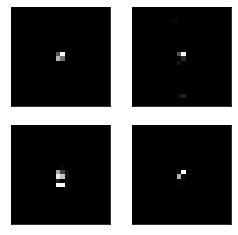

In [166]:
#Visualise images.
plot.image(train[0:4]);

In [167]:
#Split into train/test sets.
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(train, target, weights, test_size = 0.3)

#Re-verify data shapes.
x_train.shape, y_train.shape, w_train.shape, x_test.shape, y_test.shape, w_test.shape

((315000, 24, 24, 1),
 (315000,),
 (315000,),
 (135000, 24, 24, 1),
 (135000,),
 (135000,))

### Optimisation

In [179]:
#Define testing model.

def get_model(nb_layer1, nb_layer2, nb_layer3, dropout, full_layer):
    
    opts_conv = dict(kernel_size=(3,3), activation='relu')
    opts_pool = dict(pool_size=(2,2))

    i = Input(shape=(24,24,1), name = 'Input')
    x = Conv2D(int(nb_layer1), **opts_conv)(i)
    x = MaxPooling2D(**opts_pool)(x)
    
    x = Conv2D(int(nb_layer2), **opts_conv)(x)
    x = MaxPooling2D(**opts_pool)(x)
    
    x = Conv2D(int(nb_layer3), **opts_conv)(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    x = Dense(full_layer, activation='relu')(x)
    o = Dense(3, activation='softmax', name = 'Output')(x)
    
    return Model(i, o)

def fit_with(nb_layer1, nb_layer2, nb_layer3, dropout, full_layer, lr):
     
    model = get_model(nb_layer1, nb_layer2, nb_layer3, dropout, full_layer)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(optimizer = optimizer, 
            metrics = ['accuracy'], 
            loss = 'sparse_categorical_crossentropy')
    
    model.fit(x_train, y_train, epochs = 1, sample_weight = w_train, 
              verbose = 1, batch_size = 128, validation_data = [x_test, y_test, w_test], shuffle = True);
    
    loss, acc = model.evaluate(x_test, y_test, sample_weight = w_test)
    print('Loss: {:.4f}, Accuracy: {:.4f}'.format(loss, acc*100))
    
    return acc



In [180]:
#Peform optimisation.

pbounds = {'nb_layer1': (8,64), 'nb_layer2': (8,64), 'nb_layer3': (8,64), 
           'dropout': (0.1,0.5), 'full_layer': (20,150), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(f = fit_with, pbounds = pbounds, verbose = 2,  random_state = 1)

optimizer.maximize(init_points= 3, n_iter= 2)

print(optimizer.max)



|   iter    |  target   |  dropout  | full_l... |    lr     | nb_layer1 | nb_layer2 | nb_layer3 |
-------------------------------------------------------------------------------------------------
Train on 315000 samples, validate on 135000 samples
135000/135000 [==============================] - 24s 174us/sample - loss: 0.7227 - acc: 0.7194
Loss: 0.7227, Accuracy: 71.9378
|  1        |  0.7194   |  0.2668   |  113.6    |  0.000101 |  24.93    |  16.22    |  13.17    |
Train on 315000 samples, validate on 135000 samples
135000/135000 [==============================] - 34s 251us/sample - loss: 0.5941 - acc: 0.7799
Loss: 0.5941, Accuracy: 77.9904
|  2        |  0.7799   |  0.1745   |  64.92    |  0.004028 |  38.17    |  31.47    |  46.37    |
Train on 315000 samples, validate on 135000 samples
135000/135000 [==============================] - 36s 265us/sample - loss: 0.6354 - acc: 0.7587
Loss: 0.6354, Accuracy: 75.8748
|  3        |  0.7587   |  0.1818   |  134.2    |  0.000371 |  45.55   

### Network architecture and training

In [22]:
def CNN_Classifier(image, classes):
    '''
    Convolutiona Neural Network architecture for image classification.
    param image: (N,N,3) image 
    param classes: list containing image classes
    
    return: Keras Model
    '''
    
    #Common layer params
    opts_conv = dict(kernel_size=(3,3), activation='relu')
    opts_pool = dict(pool_size=(2,2))

    #Network architecture.
    i = Input(shape=image.shape, name = 'Input')
    x = Conv2D(8, **opts_conv)(i)
    x = MaxPooling2D(**opts_pool)(x)
    
    x = Conv2D(16, **opts_conv)(x)
    x = MaxPooling2D(**opts_pool)(x)
    
    x = Conv2D(24, **opts_conv)(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(50, activation='relu')(x)
    o = Dense(len(classes), activation='softmax', name = 'Output')(x)


    return Model(i, o, name='CNN_Classifier')

In [23]:
#Create CNN model.
cnn = CNN_Classifier(x_train[0], classes)

#Compile model.
cnn.compile(optimizer='adam', 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy'])

#Examine trainable parameters.
cnn.summary()

Model: "CNN_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 24, 24, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 24)          3480      
_________________________________________________________________
flatten (Flatten)            (None, 96)             

In [24]:
#Train model.
cnn.fit(x_train, y_train, epochs = 10, verbose = 1, batch_size = 128,
        sample_weight = w_train, validation_data = [x_test, y_test, w_test], shuffle = True);

Train on 315000 samples, validate on 135000 samples
Epoch 1/10
315000/315000 [==============================] - 85s 269us/sample - loss: 0.7175 - acc: 0.7053 - val_loss: 0.6216 - val_acc: 0.7686
Epoch 2/10
315000/315000 [==============================] - 95s 300us/sample - loss: 0.6407 - acc: 0.7533 - val_loss: 0.6045 - val_acc: 0.7748
Epoch 3/10
315000/315000 [==============================] - 89s 283us/sample - loss: 0.6212 - acc: 0.7646 - val_loss: 0.6011 - val_acc: 0.7732
Epoch 4/10
315000/315000 [==============================] - 91s 287us/sample - loss: 0.6052 - acc: 0.7712 - val_loss: 0.5712 - val_acc: 0.7880
Epoch 5/10
315000/315000 [==============================] - 77s 243us/sample - loss: 0.5936 - acc: 0.7780 - val_loss: 0.5765 - val_acc: 0.7827
Epoch 6/10
315000/315000 [==============================] - 90s 284us/sample - loss: 0.5858 - acc: 0.7822 - val_loss: 0.5546 - val_acc: 0.8052
Epoch 7/10
315000/315000 [==============================] - 76s 242us/sample - loss: 0.577

### Performance Evaluation

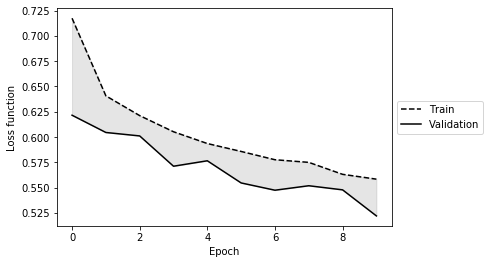

In [25]:
#Plot training loss and validation loss curves.
plot.loss(cnn);

In [63]:
#Evaluate model accuracy.
loss, acc = cnn.evaluate(x_test, y_test, sample_weight = w_test)
print('Model accuracy (weighted) = {:.2f}%'.format(acc*100))

loss, acc = cnn.evaluate(x_test, y_test)
print('Model accuracy (no weights) = {:.2f}%'.format(acc*100))

135000/135000 [==============================] - 16s 121us/sample - loss: 0.5241 - acc: 0.8116
Model accuracy (weighted) = 81.16%
135000/135000 [==============================] - 15s 110us/sample - loss: 0.5033 - acc: 0.8116
Model accuracy (no weights) = 81.16%


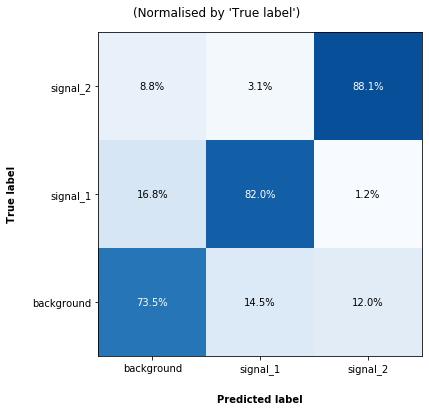

In [27]:
#Plot confusion matrix.
cm = confusion_matrix(y_test, np.argmax(cnn.predict(x_test), axis = 1))
plot.confusion_matrix(cm, labels = classes, normalise = True);

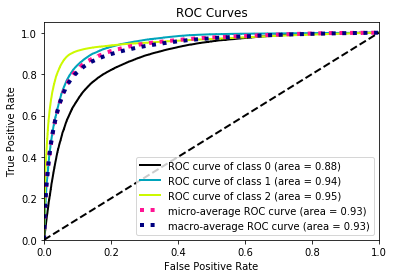

In [28]:
#Plot ROC curve.
plot_roc(y_test, cnn.predict(x_test))
plt.show()

In [181]:
#Get unlabeled image predictions and labels.
predictions = cnn.predict(test)
labels = np.argmax(predictions, axis = 1)

for i in range(len(classes)):
    print('Model predicted {} {} events.'.format(list(labels).count(i), classes[i]))

Model predicted 14575 background events.
Model predicted 15254 signal_1 events.
Model predicted 15171 signal_2 events.


In [201]:
#Accuracy evaluation.
a = imgsA_train
b = imgsB_train
c = imgsC_train

pred_a = cnn.predict(a)
pred_b = cnn.predict(b)
pred_c = cnn.predict(c)

In [202]:
ev_a = project.evaluate(pred_a, signal, weight)
ev_b = project.evaluate(pred_b, signal, weight)
ev_c = project.evaluate(pred_c, signal, weight)

print('Image A accuracy = {:.4f}% \nImage B accuracy = {:.4f}% \nImage C accuracy = {:.4f}%'.format(ev_a*100, ev_b*100, ev_c*100))

Image A accuracy = 72.3252% 
Image B accuracy = 73.1994% 
Image C accuracy = 73.1992%


### Discussion 

---

The data consisted of 450 000 pixel images in 3 equally sized classes (A, B and C), correponding to 150 000 measurements, including respective target labels and corresponding weights. Each image had a defult matrix format of (24,24) corresponding to the height and width of the image. In order to use the image in training a third dimension had to be added to each image. This was used to store the colour channel of the images and was set to 1 resulting in a greyscale array of images. Copies of target and weight lists were made in order to assign labels to all 3 image classes. The image pixel data was then standardised to range [0,1]. The unlabeled and training image data had a different range of pixel intensities. This was expected because unlike a standard [0,225] picture range, in the context of particle detection the intensitie correspond to jet energies, which could take any value in the range of the collision energy. Since the unlabeled and training data represent different events the maximum pixel intensities were expected to be different. The data was then shuffled ensuring that the training images, weights and labels were shuffled in unison, so that the correct labeling was maintained. 30% of the data was left out for validation. This was a sensible split because it left a suficiantly large training dataset for the model to learn the high-level image features.

A standard CNN architecture was used in classification, consisting of 3 2D convolutional layers used for feature selection and a deep fully connected layer for classification. Dropout regularisation was used to reduce overfitting. A 40% dropout rate was large enough to prevent the model from learning irrelevant features while still allowing for a large enough learning rate to acheve a reasonable accuracy. Using a batch size of 128 significantly speed up the rate of training form around 132 second to 92 seconds per epoch. Training the model for 10 epochs was sufficient to get a good accuracy. Past the 10th epoch the learning rate decreased drastically making it comutationally inefficient to train the network further.

The classification accuracy of the model was 81.16% this was consistant with the loss curves. The weights had minimal impact on the overall accuracy. Both weighted and unweighted data was tested and produced the same 81.16% accuracy, the only difference being that applying weights to the data resulted in a slightly higher end loss. The most misclassified category was the background with a sensitivity of 73.5%, compared to 82% and 88.1% for signal 1 and signal 2 respectively. The confusion matrix is strongly diagonal. Signal 1 and background were the most frequant mutually misclassified classes. This could have been expected, since the two have very similar masses (100 GeV) compared to signal 2 (500 GeV). 

The predicted distribution is relatively even with signal 1 being the most popular class and the background the least. This result looks sensible when compared with literature. Various architectures were tested to see the effect of Batch Normalisation and regulatisation in a model. However, these implementations made the model perform much poorer, either by reducing the accuracy or producing results that do not make sense, for example predicting that the entire unlabeled dataset belongs to a single class. Therefore, a simple network architecture was favoured over a more complicated one.

---

### (2) A (variational) auto-encoder for image generation

In [31]:
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers import Reshape, Lambda
from tensorflow.python.keras.models import Sequential

The image data used for this investigation was used and preprocessed above when examining Convolutional Neural Network methods. However, the preprocessed image data was examined in order to verify that it has the expected format.

In [32]:
#Inspect data.

print('Test image shape: {} \nTrain image shape: {} \nNumber of targets: {} \nNumber of weights: {}'
      .format(test.shape[1:], train.shape[1:], target.shape[0], weights.shape[0]))

Test image shape: (24, 24, 1) 
Train image shape: (24, 24, 1) 
Number of targets: 450000 
Number of weights: 450000


### Network architecture and training

In [33]:
def sample(args):
    #Sampling latent space.
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    sample = z_mean + K.exp(0.5 * z_log_var) * epsilon
    return sample

In [34]:
def VAE(latent_dim):
    nb_nodes = 128
    
    def encoder(latent_dim):
        i = Input(shape = test.shape[1:], name = 'Input')
        x = Flatten()(i)
        x = Dense(nb_nodes, activation = 'relu')(x)
        x = Dense(nb_nodes, activation = 'relu')(x)
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
        o = [z_mean, z_log_var, z]
        
        return Model(i, o, name = 'Encoder')
    
    def decoder(latent_dim):
        i = Input(shape=(latent_dim,))
        x = Dense(nb_nodes, activation = 'relu', input_dim = latent_dim)(i) 
        x = Dense(nb_nodes, activation = 'relu')(x)
        x = Dense(np.prod(test.shape[1:]), activation='sigmoid')(x)
        o = Reshape(test.shape[1:])(x)
        return Model(i,o, name = 'Decoder')
    
    
    encoder = encoder(latent_dim)
    decoder = decoder(latent_dim)
        
    inputs = encoder.inputs
    outputs = decoder(encoder(inputs)[2])
        
    return Model(inputs, outputs, name = 'VAE')


In [35]:
def compile_model(model):
    
    encoder = model.get_layer('Encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean = encoder.get_layer('z_mean').output

    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) 
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value
 
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    model.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return
    

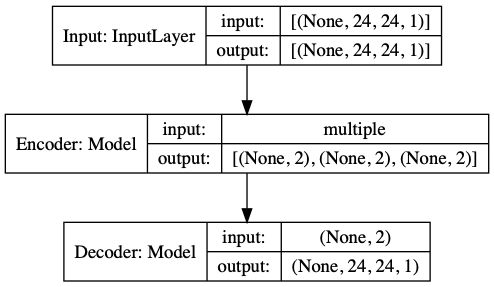

In [36]:
#Create, compile and display model.
vae = VAE(2)
compile_model(vae)
plot_model(vae, show_shapes = True)

In [37]:
#Train model.
vae.fit(x_train, x_train, epochs = 10, verbose = 1, batch_size = 128,
        sample_weight = w_train, validation_data = [x_test, x_test, w_test], shuffle = True)

Train on 315000 samples, validate on 135000 samples
Epoch 1/10
315000/315000 [==============================] - 36s 113us/sample - loss: 7.3621 - reco_loss: 7.2427 - kl_loss: 0.1810 - val_loss: 3.3096 - val_reco_loss: 3.3084 - val_kl_loss: 0.0076
Epoch 2/10
315000/315000 [==============================] - 33s 105us/sample - loss: 3.2936 - reco_loss: 3.2918 - kl_loss: 0.0030 - val_loss: 3.2907 - val_reco_loss: 3.2969 - val_kl_loss: 7.7992e-04
Epoch 3/10
315000/315000 [==============================] - 32s 103us/sample - loss: 3.2853 - reco_loss: 3.2863 - kl_loss: 3.9208e-04 - val_loss: 3.2844 - val_reco_loss: 3.2912 - val_kl_loss: 1.5101e-04
Epoch 4/10
315000/315000 [==============================] - 33s 105us/sample - loss: 3.2832 - reco_loss: 3.2844 - kl_loss: 9.9550e-05 - val_loss: 3.2840 - val_reco_loss: 3.2913 - val_kl_loss: 6.3446e-05
Epoch 5/10
315000/315000 [==============================] - 33s 106us/sample - loss: 3.2819 - reco_loss: 3.2832 - kl_loss: 5.7003e-05 - val_loss: 3.

### Performance Evaluation

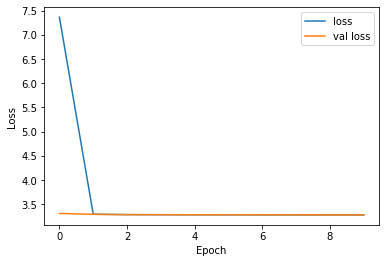

In [38]:
epochs = list(range(len(vae.history.history['loss'])))
loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']

plt.plot(epochs, loss, label = 'loss')
plt.plot(epochs, val_loss, label = 'val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

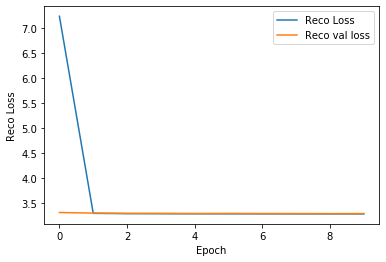

In [39]:
reco_loss = vae.history.history['reco_loss']
reco_val_loss = vae.history.history['val_reco_loss']

plt.plot(epochs, reco_loss, label = 'Reco Loss')
plt.plot(epochs, reco_val_loss, label = 'Reco val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Reco Loss')
plt.show()

### Latent Space Visualisation

In [40]:
#Get encoder predictions for 3 image types (A, B and C)
encoder = vae.get_layer('Encoder')
predictionA = encoder.predict(imgsA_train)
predictionB = encoder.predict(imgsB_train)
predictionC = encoder.predict(imgsC_train)
meanA = predictionA[0]
meanB = predictionB[0]
meanC = predictionC[0]

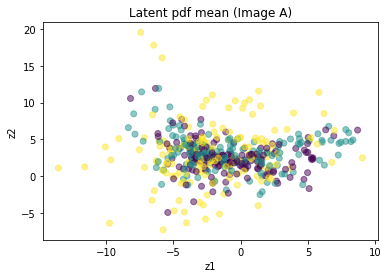

In [41]:
plt.scatter(meanA[:,0][:500],meanA[:,1][:500], c = signal[:500], alpha = 0.5)
plt.title('Latent pdf mean (Image A)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.show()

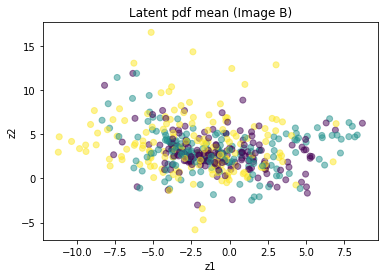

In [42]:
plt.scatter(meanB[:,0][:500],meanB[:,1][:500], c = signalB[:500], alpha = 0.5)
plt.title('Latent pdf mean (Image B)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.show()

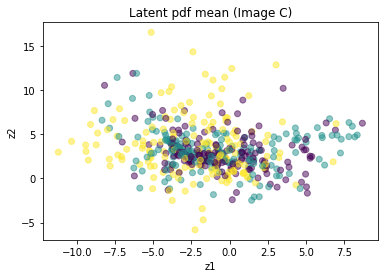

In [43]:
plt.scatter(meanC[:,0][:500],meanC[:,1][:500], c = signalC[:500], alpha = 0.5)
plt.title('Latent pdf mean (Image C)')
plt.xlabel('z1')
plt.ylabel('z2')
plt.show()

### Image Generation

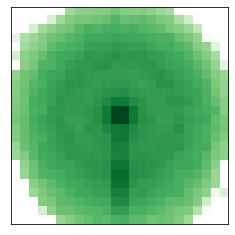

In [44]:
z1_gen = np.linspace(-10,10, num = 1000)
z2_gen = np.linspace(-20,-10, num = 1000)

grid = np.meshgrid(z1_gen, z2_gen)
z1_flat = grid[0].flatten()
z2_flat = grid[1].flatten()

latent = np.column_stack((z1_flat, z2_flat))

decoder = vae.get_layer('Decoder')
pred_image = decoder.predict(latent)
plot.image(GetAverageImage(pred_image), cmap = 'Greens');

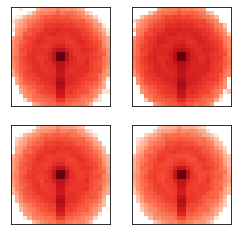

In [45]:
z1_gen = np.linspace(-10,0, num = 1000)
z2_gen = np.linspace(-5,15, num = 1000)

grid = np.meshgrid(z1_gen, z2_gen)
z1_flat = grid[0].flatten()
z2_flat = grid[1].flatten()

latent = np.column_stack((z1_flat, z2_flat))

decoder = vae.get_layer('Decoder')
pred_image = decoder.predict(latent)
plot.image([GetAverageImage(pred_image[:250]), GetAverageImage(pred_image[250:500]), 
            GetAverageImage(pred_image[500:750]), GetAverageImage(pred_image[750:1000])], cmap = 'Reds');

### Discussion

---

The variational autoencoder was made up of two different models, an encoder and decoder. The encoder, which takes an image as input and encodes it onto the latent space in the form of a flat latent vector. On the other hand, the decoder does the reverse, it takes a flat latent vector and uses it to generate an image matrix.

By sampling the 2 dimensional latent space pixelated images of jet constituents could be generated. The generated samples look very reasonable when compared to the original data. The images show slight variations when taking systematic samples accross the entire latent space. The original images look fairly similar, which explains the lack of significant variation accross the latent space. Generated images most closely resemble Type B and Type C, characterised by a darker strip ath the lower section of the image. Therefore, it is suspected that the model did not generalise well to Type A images.

---

### (3) A flat deep neural network (DNN) classifier on the high-level variables

In [130]:
#Imports.
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.regularizers import l1_l2

### Data Preperation

In [47]:
# Load the high-level variable test dataset
df_test = pd.read_hdf(dir_test + 'variables.h5')
df_test.keys()

Index(['weight', 'pt', 'eta', 'phi', 'mass', 'trimmed_mass', 'tau1', 'tau2',
       'tau3', 'tau21', 'tau32', 'e2_1', 'e2_2', 'e3_1', 'e3_2', 'C2_1',
       'C2_2', 'D2_1', 'D2_2', 'KtDR', 'split12', 'zcut12'],
      dtype='object')

In [114]:
#Select relevant training features.
features = ['pt', 'eta', 'phi', 'mass', 'trimmed_mass', 'tau21']
target_var = ['signal']

#Divide data into inputs and targets.
train = np.array(df_variables[features])
target = np.array(df_variables[target_var])
weights = np.array(df_variables['weight'])

#Shuffle data.
perm_train = np.random.permutation(train.shape[0])

train = train[perm_train]
target = target[perm_train]
weights = weights[perm_train]

#Standardise data.
train = StandardScaler().fit_transform(train)

#Split into train/test sets.
x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(train, target, weights, test_size = 0.3)

#Verify data shapes and normalisation.
print('Mean = {:.6f} \nStandard Deviation = {:.6f}'.format(np.mean(train), np.std(train)))

Mean = 0.000000 
Standard Deviation = 1.000000


### Optimisation

In [146]:
#Define testing model.

def get_model(nb_layer1, nb_layer2, nb_layer3, dropout1, dropout2):
    
    opts_dense = dict(activation = 'relu')
    
    i = Input(shape = 6, name = 'Input')
    x = Dense(nb_layer1, **opts_dense)(i)
    x = Dropout(dropout1)(x)
    x = Dense(nb_layer2, **opts_dense)(x)
    x = Dropout(dropout2)(x)
    x = Dense(nb_layer3, **opts_dense)(x)
    o = Dense(3, activation = 'softmax', name = 'Output')(x)
    
    return Model(i, o)

def fit_with(nb_layer1, nb_layer2, nb_layer3, dropout1, dropout2, lr):
     
    model = get_model(nb_layer1, nb_layer2, nb_layer3, dropout1, dropout2)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    
    model.compile(optimizer = optimizer, 
            metrics = ['accuracy'], 
            loss = 'sparse_categorical_crossentropy')
    
    model.fit(x_train, y_train, epochs = 5, sample_weight = w_train, 
              verbose = 0, batch_size = 64, validation_data = [x_test, y_test, w_test], shuffle = True);
    
    loss, acc = model.evaluate(x_test, y_test, sample_weight = w_test)
    print('Loss: {:.4f}, Accuracy: {:.4f}'.format(loss, acc*100))
    
    return acc



In [148]:
#Peform optimisation.

pbounds = {'nb_layer1': (10,100), 'nb_layer2': (10,100), 'nb_layer3': (10,100), 
           'dropout1': (0.1,0.5), 'dropout2': (0.1,0.5), 'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(f = fit_with, pbounds = pbounds, verbose = 2,  random_state = 1)

optimizer.maximize(init_points= 5, n_iter= 5)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)


|   iter    |  target   | dropout1  | dropout2  |    lr     | nb_layer1 | nb_layer2 | nb_layer3 |
-------------------------------------------------------------------------------------------------
45000/45000 [==============================] - 3s 63us/sample - loss: 0.6073 - acc: 0.7645
Loss: 0.6073246590402391, Accuracy: 0.7645111083984375
|  1        |  0.7645   |  0.2668   |  0.3881   |  0.000101 |  37.21    |  23.21    |  18.31    |
45000/45000 [==============================] - 3s 68us/sample - loss: 0.4505 - acc: 0.8447
Loss: 0.450465548019939, Accuracy: 0.8447111248970032
|  2        |  0.8447   |  0.1745   |  0.2382   |  0.004028 |  58.49    |  47.73    |  71.67    |
45000/45000 [==============================] - 2s 54us/sample - loss: 0.4657 - acc: 0.8451
Loss: 0.46573692153824703, Accuracy: 0.8450666666030884
|  3        |  0.8451   |  0.1818   |  0.4512   |  0.000371 |  70.34    |  47.56    |  60.28    |
45000/45000 [==============================] - 2s 53us/sample - loss: 0.

In [149]:
print(optimizer.max)

{'target': 0.8514444231987, 'params': {'dropout1': 0.15615477543809353, 'dropout2': 0.17924059563395153, 'lr': 0.008027371229887814, 'nb_layer1': 97.14354181474577, 'nb_layer2': 38.208176034331856, 'nb_layer3': 72.30903541023827}}


### Network architecture and training

In [152]:
def DNN_Classifier(nb_feats, nb_target):
    
    opts_dense = dict(activation = 'relu')
    
    i = Input(shape = nb_feats, name = 'Input')
    x = Dense(97, **opts_dense)(i)
    x = Dropout(0.16)(x)               
    x = Dense(38, **opts_dense)(x)
    x = Dropout(0.18)(x)
    x = Dense(72, **opts_dense)(x)
    o = Dense(nb_target, activation = 'softmax', name = 'Output')(x)
    
    return Model(i, o, name = 'DNN_Classifier')

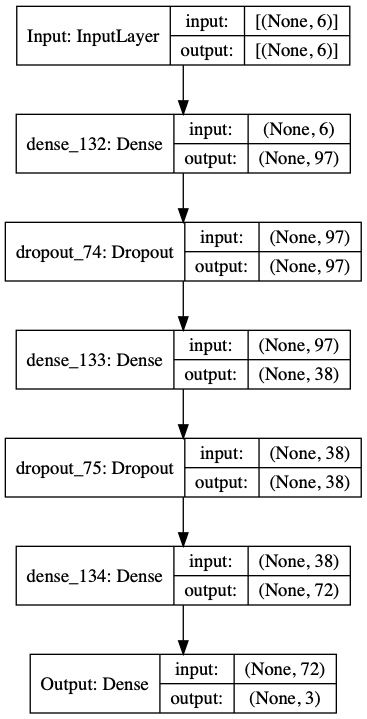

In [154]:
#Construct and compile model.

dnn = DNN_Classifier(x_train.shape[1], 3)
dnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.008), 
            metrics = ['accuracy'], 
            loss = 'sparse_categorical_crossentropy')

#Inspect model structure.
plot_model(dnn, show_shapes = True)

In [155]:
#Train model.
dnn.fit(x_train, y_train, epochs = 50, sample_weight = w_train, verbose = 1, batch_size = 64, validation_data = [x_test, y_test, w_test], shuffle = True);

Train on 105000 samples, validate on 45000 samples
Epoch 1/50
105000/105000 [==============================] - 9s 90us/sample - loss: 0.5389 - acc: 0.8099 - val_loss: 0.4680 - val_acc: 0.8456
Epoch 2/50
105000/105000 [==============================] - 9s 87us/sample - loss: 0.4834 - acc: 0.8351 - val_loss: 0.4675 - val_acc: 0.8354
Epoch 3/50
105000/105000 [==============================] - 8s 77us/sample - loss: 0.4705 - acc: 0.8391 - val_loss: 0.4676 - val_acc: 0.8411
Epoch 4/50
105000/105000 [==============================] - 8s 73us/sample - loss: 0.4690 - acc: 0.8413 - val_loss: 0.4539 - val_acc: 0.8462
Epoch 5/50
105000/105000 [==============================] - 8s 74us/sample - loss: 0.4698 - acc: 0.8403 - val_loss: 0.4542 - val_acc: 0.8467
Epoch 6/50
105000/105000 [==============================] - 8s 77us/sample - loss: 0.4674 - acc: 0.8412 - val_loss: 0.4537 - val_acc: 0.8450
Epoch 7/50
105000/105000 [==============================] - 9s 83us/sample - loss: 0.4668 - acc: 0.8406

### Performance Evaluation

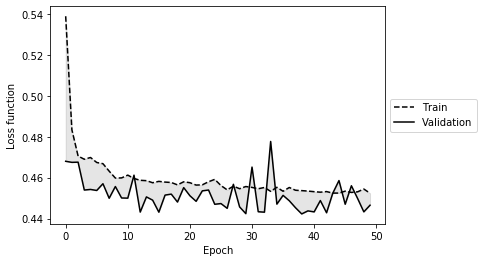

In [156]:
#Plot loss and save model.
dnn.save('dnn.h5')
plot.loss(dnn);

In [157]:
#Evaluate model accuracy.
loss, acc = dnn.evaluate(x_test, y_test, sample_weight = w_test)
print('Model accuracy (weighted) = {:.2f}%'.format(acc*100))
loss, acc = dnn.evaluate(x_test, y_test)
print('Model accuracy (no weights) = {:.2f}%'.format(acc*100))

45000/45000 [==============================] - 3s 70us/sample - loss: 0.4465 - acc: 0.8464
Model accuracy (weighted) = 84.64%
45000/45000 [==============================] - 4s 93us/sample - loss: 0.4292 - acc: 0.8464
Model accuracy (no weights) = 84.64%


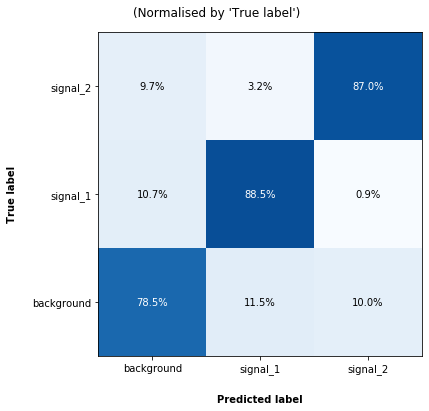

In [158]:
#Plot confusion matrix.
cm = confusion_matrix(y_test, np.argmax(dnn.predict(x_test), axis = 1))
plot.confusion_matrix(cm, labels = classes, normalise = True);

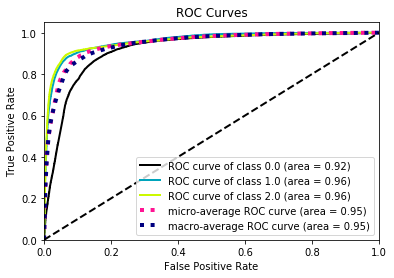

In [159]:
#Plot ROC curve.
plot_roc(y_test, dnn.predict(x_test))
plt.show()

In [160]:
#Get test predictions and labels.
predictions = dnn.predict(df_test[features])
labels = np.argmax(predictions, axis = 1)

for i in range(len(classes)):
    print('Model predicted {} {} events.'.format(list(labels).count(i), classes[i]))

Model predicted 14996 background events.
Model predicted 0 signal_1 events.
Model predicted 4 signal_2 events.


### Discussion

---

The high level variables contained no qualitative data was given, therefore One-Hot encoding was not needed. The data was read in and normalised with a 30% split left for validation. Bayesian Optimisation was used to optimise key hyperparameters, namely the sizes of the fully connected layers, dropout rates and optimiser learning rate. Afther 4 iterations the optimal combination of hyperparameters was found and used for thaining the model. After 50 epochs of training a 84.64% accuracy was reached. The most misclassified category was background mutually misclassified with signal 1. These results are similar to the performance of the CNN. However, test data labels were predicted drastically different. with nearly all of the events being predicted as background. This seams very strange, since all the performance metrics (accuracy, loss plots, ROC analysis) used imply that the model is performing exceptionally. Further testing into the models architecture was needed.

---